# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

### Problem statement: 
- In this capstone project, we need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR']= '/content/drive/MyDrive/Colab Notebooks/Image Captioning'

In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks/Image Captioning'

/content/drive/MyDrive/Colab Notebooks/Image Captioning


In [5]:
#!kaggle datasets download -d adityajn105/flickr8k

In [6]:
#!unzip flickr8k.zip

In [7]:
#Import all the required necessary libraries
import dill
#dill.__version__
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from skimage import io
pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption

import collections
from wordcloud import WordCloud,STOPWORDS

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

#from gtts import gTTS
#from playsound import playsound
#from IPython import display

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


In [8]:
#pip install gTTs

In [9]:
#pip install playsound

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [10]:
#Import the dataset and read the image into a seperate variable

images='Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


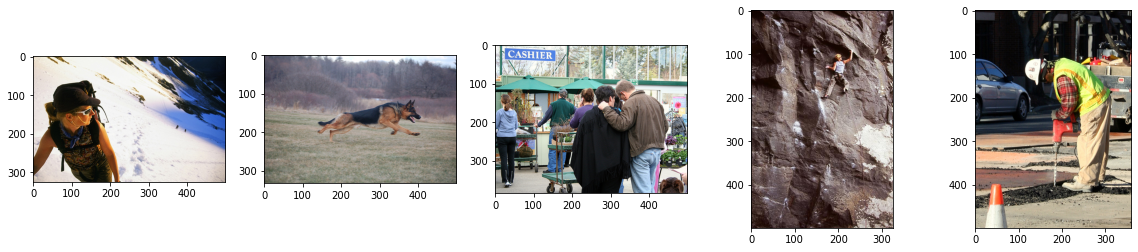

In [11]:
#Visualise both the images & text present in the dataset
# Read an image from a file into an array(imread)
img=all_imgs[:5]
fig,ax=plt.subplots(1,5)
fig.set_figwidth(20)
for axes,i in zip(ax,img):
  axes.imshow(io.imread(i))


In [12]:
#Import the dataset and read the text file into a seperate variable

text_file='captions.txt'
def load_doc(filename):
    #your code here
    file=open(filename,'r')
    text=file.read()
    file.close()
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [13]:

path='Images/'
all_img_id=[] #store all the image id here
all_img_vector=[] #store all the image path here
annotations=[] #store all the captions here
with open('captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    # for line in fo:
    #     split_arr=line.split(',')
    #     all_img_id.append(split_arr[0])
    #     annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
    #     all_img_vector.append(path+split_arr[0])
    for line in fo:
      x=line.split(',')
      #print(x)
      all_img_id.append(x[0].split('.')[0])
      all_img_vector.append(path+str(x[0]))
      annotations.append(x[1].rstrip('.\n'))

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way
1,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin
...,...,...,...
40450,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air
40452,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles
40453,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A rock climber in a red shirt


In [14]:
# import dill
# dill.dump_session('notebook_env.db')


In [15]:
# import dill
# dill.load_session('notebook_env.db')

In [16]:
def clean_descriptions(annotations):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for i in range(len(annotations)):
    desc = annotations[i]
		# tokenize
    desc = desc.split()
		# convert to lower case
    desc = [word.lower() for word in desc]
		# remove punctuation from each token
    desc = [w.translate(table) for w in desc]
		# remove hanging 's' and 'a'
    desc = [word for word in desc if len(word)>1]
		# remove tokens with numbers in them
    desc = [word for word in desc if word.isalpha()]
		# store as string
    annotations[i] =  ' '.join(desc)

In [17]:
clean_descriptions(annotations)

In [18]:
df['captions']=annotations
df

,ID,Path,Captions,captions
0,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way,child in pink dress is climbing up set of stairs in an entry way
1,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building,girl going into wooden building
2,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e,Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin,little girl in pink dress going into wooden cabin
...,...,...,...,...
40450,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,man in pink shirt climbs rock face
40451,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air,man is rock climbing high in the air
40452,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles,person in red shirt climbing up rock face covered in assist handles
40453,997722733_0cb5439472,Images/997722733_0cb5439472.jpg,A rock climber in a red shirt,rock climber in red shirt


In [19]:
#Create a list which contains all the captions
annotations=['<start> '+ captions + ' <end>' for captions in annotations]#write your code here


#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [20]:
#Create the vocabulary & the counter for the captions
from collections import Counter
vocabulary=[] #write your code here
for captions in annotations:
  for word in captions.split():
    if word not in ['<start>','<end>']:
      vocabulary.append(word)

val_count=Counter(vocabulary)
val_count

Counter({'child': 1517,
         'in': 18182,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6496,
         'stairs': 109,
         'an': 2358,
         'entry': 1,
         'way': 48,
         'girl': 3284,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1750,
         'playhouse': 6,
         'the': 17676,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3627,
         'dog': 7956,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tricolored': 12,
         'playing': 1954,
         'with': 7308,
         'each': 399,
         'other': 667,
         'on': 10367,
         'road': 380,
         'white': 3710,
         'brown': 2471,
         'spots': 28,
         'staring': 57,
         'at': 2819,
         'street': 909,
         'two

In [21]:
len(set(vocabulary))

8571

in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097
running :  1996
through :  1979


Text(0, 0.5, 'Counts')

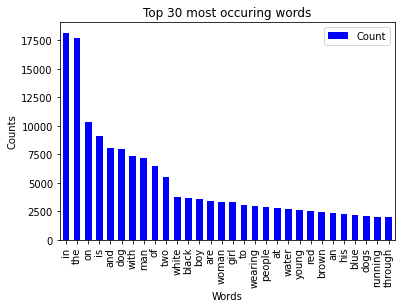

In [22]:
#Visualise the top 30 occuring words in the captions
for word, count in val_count.most_common(30):
    print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='blue')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")

#write your code here

In [23]:
# import dill
# dill.dump_session('notebook_env.db')

In [24]:
# import dill
# dill.load_session('notebook_env.db')

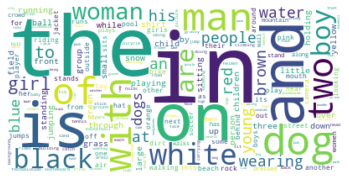

In [25]:
# Including stop words(One Letter words removed eg:- a,s)
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate_from_frequencies(val_count)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

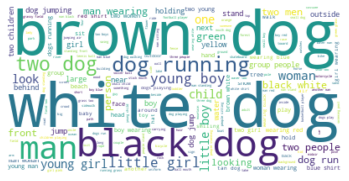

In [26]:
# Excluding Stop Words
stopwords = set(STOPWORDS)
#stopwords.update(['the','in'])
text=" ".join(vocabulary)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [27]:
# create the tokenizer
tokenizer= Tokenizer(
    num_words=5001,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token='UNK'
)
#your code here

In [28]:
# Create word-to-index and index-to-word mappings.
tokenizer.fit_on_texts(annotations)
seq = tokenizer.texts_to_sequences(annotations)
#your code here
# 0 is a reserved index that won't be assigned to any word.Hence adding pad token to 0
tokenizer.word_index['PAD']=0
tokenizer.index_word[0]='PAD'


In [29]:
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [30]:
seq[0:5]

[[2, 43, 4, 88, 169, 7, 115, 52, 390, 12, 382, 4, 28, 1, 687, 3],
 [2, 19, 309, 63, 193, 119, 3],
 [2, 37, 19, 115, 63, 193, 2354, 3],
 [2, 37, 19, 115, 5, 382, 20, 62, 2354, 3],
 [2, 37, 19, 4, 88, 169, 309, 63, 193, 2889, 3]]

In [31]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [32]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('child', 1517),
             ('in', 18182),
             ('pink', 702),
             ('dress', 332),
             ('is', 9069),
             ('climbing', 490),
             ('up', 1215),
             ('set', 105),
             ('of', 6496),
             ('stairs', 109),
             ('an', 2358),
             ('entry', 1),
             ('way', 48),
             ('<end>', 40455),
             ('girl', 3284),
             ('going', 145),
             ('into', 1046),
             ('wooden', 278),
             ('building', 485),
             ('little', 1750),
             ('playhouse', 6),
             ('the', 17676),
             ('to', 3005),
             ('her', 1102),
             ('cabin', 4),
             ('black', 3627),
             ('dog', 7956),
             ('and', 8057),
             ('spotted', 36),
             ('are', 3365),
             ('fighting', 130),
             ('tricolored', 12),
             ('playing', 1954),
        

Text(0, 0.5, 'Counts')

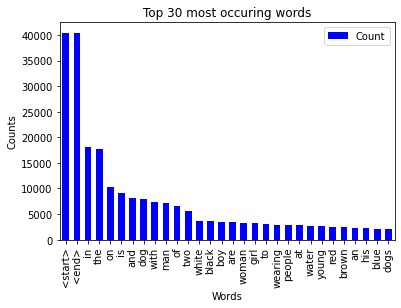

In [33]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
sorted_tokens=sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1],reverse=True)
#your code here
most_common_tokens_df = pd.DataFrame(sorted_tokens[:30], columns = ['Word', 'Count'])
most_common_tokens_df.plot.bar(x='Word',y='Count',width=0.6,color='blue')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")

In [34]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seqs_len=[len(s) for s in seq] #storing all lengths in list.Can be used if needed in future
longest_word_length= max(train_seqs_len) #Python list method max returns the elements from the list with maximum value.

# Calculates the longest_word_length to pad all sequences to be the same length as the longest one.
# maxlen=longest_word_length is  optional as by default the seq will be padded to longest available sentence
cap_vector= pad_sequences(seq, padding='post',maxlen=longest_word_length,dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 31)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [35]:
IMAGE_SHAPE= (299, 299)

In [36]:
#write your code here
#Let's see how preprocessed image looks by preprocessing first 5 images alone.
preprocessed_img=[]
for img in all_imgs[0:5]:
    img = tf.io.read_file(img,name=None)
    # by default channels=0 which indicates to use the number of channels in the JPEG-encoded image.
    img = tf.image.decode_jpeg(img,channels=0) #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None)#Default value for data format is None # Normalization also happens here
    # It refers to global setting tf.keras.backend.image_data_format()
    preprocessed_img.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)


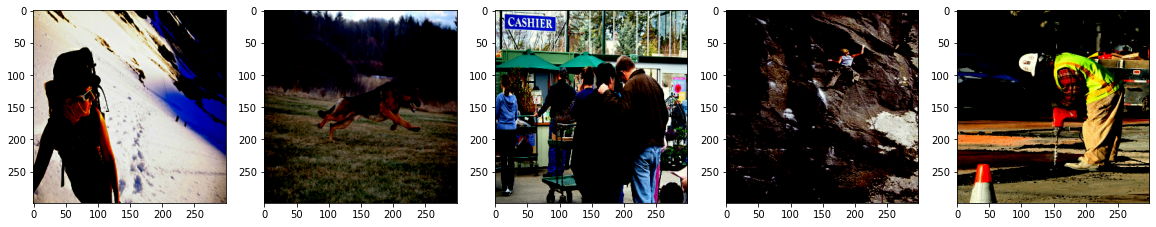

In [37]:
Display_Images= preprocessed_img[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for ax,image in zip(axes, Display_Images):
    print("Shape after resize :", image.shape)
    ax.imshow(image)
    

In [38]:
#write your code here to create the dataset consisting of image paths

In [39]:
#write your code here for creating the function. This function should return images & their path
# Putting the above code in load_image function
def load_image(image_path):
    # Write your pre-processing steps here
    img = tf.io.read_file(image_path,name=None)
    # By default channels=0 which indicates to use the number of channels in the JPEG-encoded image.
    # Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.decode_jpeg(img,channels=3) 
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path

In [40]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
# Slices of an array in the form of objects by using tf.data.Dataset.from_tensor_slices() method.It is done for fast processing
# https://www.geeksforgeeks.org/tensorflow-tf-data-dataset-from_tensor_slices/

#Checking how tensor_slices work
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
for element in dataset:
  print(element)




tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)


In [41]:
# Mapping each image full path including name to the function to preprocess the image

#  Storing unique path in list which will be given as input 
training_list = list(set(all_img_vector)) 

# Creating a Dataset using tf.data.Dataset.from_tensor_slice
Image_Data_New = tf.data.Dataset.from_tensor_slices(training_list)

# Mappng load_image function across the elements of the above dataset.
# num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available GPU.
Image_Data_New = Image_Data_New.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Keeping batch_size=32 (32 consecutive elements of this dataset is combined in a single batch).
# We don't want to drop the last batch if it contains element less than 32.So let's set drop_remainder=False 
Image_Data_New= Image_Data_New.batch(32,drop_remainder=False)

In [42]:
Image_Data_New

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [43]:
# When loading a given model, the “include_top” argument can be set to False, in which case the fully-connected output layers of the model used to make 
# predictions is not loaded, allowing a new output layer to be added and trained
# Additionally, when the “include_top” argument is False, the “input_tensor” argument must be specified, allowing the expected fixed-sized input of the model to be changed.
# https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input =image_model.inputs #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = keras.Model(new_input,hidden_layer)#build the final model using both input & output layer

87924736/87910968 [==============================] - 1s 0us/step


In [44]:
# shape=(None, 299,299 , 3) if include_top=True
new_input

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>]

In [45]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [46]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
# https://www.tensorflow.org/api_docs/python/tf/reshape
from tqdm import tqdm
feature_dict={}
for image,path in tqdm(Image_Data_New): #using tqdm to check progress bar
    batch_features = image_features_extract_model(image)
    #print(batch_features.get_shape().as_list())
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    #print(batch_features.get_shape().as_list())
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8") # converting to numpy array and then decoding to original form 
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [04:21<00:00,  1.04s/it]


In [47]:
list(feature_dict.items())[:2]

[('Images/2969380952_9f1eb7f93b.jpg',
  array([[0.3006289 , 0.        , 0.956421  , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.02968424, ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.54593086],
         ...,
         [0.        , 0.        , 0.6449459 , ..., 0.        , 0.        ,
          0.05871145],
         [0.        , 0.        , 1.8454947 , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 1.0792298 , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('Images/1463638541_c02cfa04dc.jpg',
  array([[0.11246029, 0.08809114, 0.        , ..., 0.06670359, 0.        ,
          0.        ],
         [0.        , 0.48022637, 0.        , ..., 0.96185875, 0.        ,
          0.5861933 ],
         [0.        , 0.        , 0.        , ..., 2.003922  , 0.4838376 ,
          2.1856904 ],
         .

In [48]:
# Total image=8091, Batch=32, 8091%32=27.Hence, last batch will contain 27 image
print(batch_features.shape) # Last batch shape
print(batch_f.shape)

(27, 64, 2048)
(64, 2048)


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [49]:
#write your code here
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [50]:
# Total Data =8091 *5 =40455 , 40455-8091=32364
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [51]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_path,cap_vec):# your input variable goes here
  img_tensor = feature_dict[image_path.decode("utf-8")]# write your code here to extract the features from the dictionary stored earlier
  return img_tensor,cap_vec

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [52]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
# https://www.tensorflow.org/api_docs/python/tf/numpy_function
# Why to use tf.numpy_function()->Given a python function func wrap this function as an operation in a TensorFlow function.
# func must take numpy arrays as its arguments and return numpy arrays as its outputs.0
BATCH_SIZE=32
BUFFER_SIZE=1000
def gen_dataset(images_path,cap_vects):#your input variables):

   # your code goes here to create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((images_path, cap_vects))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE,drop_remainder=False)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset



In [53]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [54]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 31)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [55]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_dim = 256 
units = 512
vocab_size = 5001#top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [56]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = layers.Dense(embed_dim)#build your Dense layer with relu activation
        
    def call(self, features):
        features = tf.nn.relu(self.dense(features)) # extract the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

In [57]:
encoder=Encoder(embedding_dim)

### Attention model

In [58]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)#build your Dense layer
        self.W2 = layers.Dense(units)#build your Dense layer
        self.V = layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden,axis=1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.nn.softmax(score,axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights* features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        # https://stackoverflow.com/questions/47157692/how-does-reduce-sum-work-in-tensorflow
        
        context_vector = tf.reduce_sum(context_vector,axis=1)# reduce the shape to (batch_size, embedding_dim)
        # the tensor is reduced along the second dimension (columns)

        return context_vector, attention_weights

### Decoder

In [59]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = layers.Embedding(vocab_size,embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)#build your Dense layer
        self.d2 = layers.Dense(vocab_size)#build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden)#create your context vector & attention weights from attention model
        embed =  self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state =self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [60]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [61]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [62]:
optimizer =tf.keras.optimizers.Adam(lr=0.001) #define the optimizer
loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE) #define your loss object
# we always need to choose appropriate loss function.Let us use crossentropy SparseCategoricalCrossentropy.
# It calculates loss between the labels and predictions.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [63]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [64]:
checkpoint_path = 'checkpoint/' # "your checkpoint path"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [65]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [70]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0]) # Reset State is not there
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    # Compute the gradients with tf.GradientTape.
    # Process the gradients as you wish.
    # Apply the processed gradients with apply_gradients().
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        encoder_output=encoder(img_tensor)
        for i in range(1,target.shape[1]):
          prediction,hidden,_= decoder(dec_input,encoder_output,hidden)
          loss+= loss_function(target[:,i],prediction)
          #Teacher forcing
          dec_input=tf.expand_dims(target[:,i],axis=1)
        
    avg_loss=loss/int(target.shape[1])
    trainable_var=encoder.trainable_variables + decoder.trainable_variables
    grad=tape.gradient(loss,trainable_var)
    optimizer.apply_gradients(zip(grad,trainable_var))

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [74]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0]) # Reset State is not there
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        encoder_output=encoder(img_tensor)
        for i in range(1,target.shape[1]):
          prediction,hidden,_= decoder(dec_input,encoder_output,hidden)
          loss+= loss_function(target[:,i],prediction)
          #Teacher forcing
          dec_input=tf.expand_dims(target[:,i],axis=1)
        
    avg_loss=loss/int(target.shape[1])
    trainable_var=encoder.trainable_variables + decoder.trainable_variables
    grad=tape.gradient(loss,trainable_var)
    optimizer.apply_gradients(zip(grad,trainable_var))

        
    return loss, avg_loss

In [72]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch,(img_tensor,target)) in enumerate(test_dataset):
      batch_loss,batch_avg_loss=test_step(img_tensor,target)
      total_loss+=batch_avg_loss
    avg_test_loss= total_loss/test_num_steps
    return avg_test_loss

In [75]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.846, & test loss is 0.907
Time taken for 1 epoch 342.2192521095276 sec

Test loss has been reduced from 100.000 to 0.907


  7%|▋         | 1/15 [05:44<1:20:17, 344.13s/it]

For epoch: 2, the train loss is 0.798, & test loss is 0.839
Time taken for 1 epoch 282.0096790790558 sec

Test loss has been reduced from 0.907 to 0.839


 13%|█▎        | 2/15 [10:26<1:06:42, 307.86s/it]

For epoch: 3, the train loss is 0.753, & test loss is 0.786
Time taken for 1 epoch 281.6684515476227 sec

Test loss has been reduced from 0.839 to 0.786


 20%|██        | 3/15 [15:08<59:14, 296.22s/it]  

For epoch: 4, the train loss is 0.712, & test loss is 0.738
Time taken for 1 epoch 280.96471524238586 sec

Test loss has been reduced from 0.786 to 0.738


 27%|██▋       | 4/15 [19:50<53:14, 290.39s/it]

For epoch: 5, the train loss is 0.674, & test loss is 0.695
Time taken for 1 epoch 282.1529633998871 sec

Test loss has been reduced from 0.738 to 0.695


 33%|███▎      | 5/15 [24:33<47:56, 287.69s/it]

For epoch: 6, the train loss is 0.639, & test loss is 0.657
Time taken for 1 epoch 282.9688124656677 sec

Test loss has been reduced from 0.695 to 0.657


 40%|████      | 6/15 [29:16<42:56, 286.23s/it]

For epoch: 7, the train loss is 0.606, & test loss is 0.623
Time taken for 1 epoch 282.2675447463989 sec

Test loss has been reduced from 0.657 to 0.623


 47%|████▋     | 7/15 [33:59<38:01, 285.16s/it]

For epoch: 8, the train loss is 0.577, & test loss is 0.591
Time taken for 1 epoch 281.67225074768066 sec

Test loss has been reduced from 0.623 to 0.591


 53%|█████▎    | 8/15 [38:41<33:09, 284.18s/it]

For epoch: 9, the train loss is 0.550, & test loss is 0.567
Time taken for 1 epoch 281.58410143852234 sec

Test loss has been reduced from 0.591 to 0.567


 60%|██████    | 9/15 [43:23<28:21, 283.57s/it]

For epoch: 10, the train loss is 0.526, & test loss is 0.538
Time taken for 1 epoch 281.2588264942169 sec

Test loss has been reduced from 0.567 to 0.538


 67%|██████▋   | 10/15 [48:05<23:34, 282.98s/it]

For epoch: 11, the train loss is 0.503, & test loss is 0.515
Time taken for 1 epoch 281.0192720890045 sec

Test loss has been reduced from 0.538 to 0.515


 73%|███████▎  | 11/15 [52:47<18:50, 282.50s/it]

For epoch: 12, the train loss is 0.483, & test loss is 0.495
Time taken for 1 epoch 281.7212972640991 sec

Test loss has been reduced from 0.515 to 0.495


 80%|████████  | 12/15 [57:29<14:07, 282.47s/it]

For epoch: 13, the train loss is 0.463, & test loss is 0.472
Time taken for 1 epoch 282.3317539691925 sec

Test loss has been reduced from 0.495 to 0.472


 87%|████████▋ | 13/15 [1:02:12<09:25, 282.55s/it]

For epoch: 14, the train loss is 0.447, & test loss is 0.457
Time taken for 1 epoch 282.2888774871826 sec

Test loss has been reduced from 0.472 to 0.457


 93%|█████████▎| 14/15 [1:06:55<04:42, 282.67s/it]

For epoch: 15, the train loss is 0.430, & test loss is 0.438
Time taken for 1 epoch 281.65007996559143 sec

Test loss has been reduced from 0.457 to 0.438


100%|██████████| 15/15 [1:11:37<00:00, 286.48s/it]


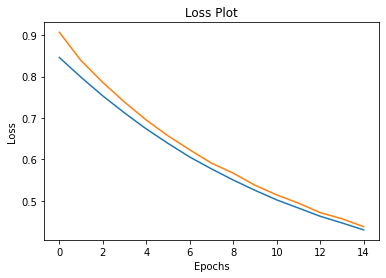

In [76]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [113]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

In [115]:
def evaluate(image):
    attention_plot = np.zeros((longest_word_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(longest_word_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
# def beam_evaluate(image, beam_index = #your value for beam index):

#     #write your code to evaluate the result using beam search
                  
#     return final_caption



In [80]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [81]:
from nltk.translate.bleu_score import sentence_bleu

In [82]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

Images/1662261486_db967930de.jpg
BLEU score: 73.02967433402216
brown and white dog jumping through black and white hoop
Prediction Caption: black and white dog jumps through black and white hoop


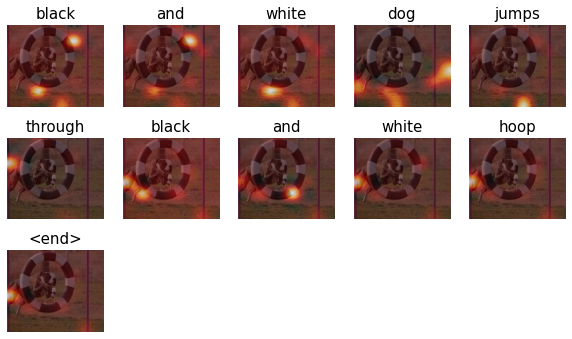

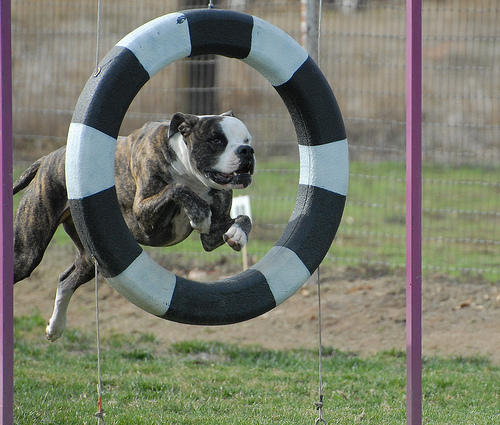

In [123]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
print(test_image)
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)) #set your weights
print(f"BLEU score: {score*100}")
print(real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
# captions=beam_evaluate(test_image)
# print(captions)

In [ ]:
#pip install gTTs

In [124]:
from gtts import gTTS
from IPython.display import Audio
tts = gTTS("Predicted Caption is: "+ pred_caption) 
tts.save('s.wav')
sound_file = 's.wav'
Audio(sound_file, autoplay=True)

### Summary

- In this project, we firstly read the image and captions file. Once proper cleaning and conversion to proper shape and size of images and captions done, we extracted the feature of images using InceptionV3 model.
- After that we build the Encoder, Attention and Decoder Model using TensorFlow sub classing method.
- Encoder Model- To bring the image features to embedding dim shape and apply proper activation for smooth processing.
- Attention Model- We used the attention model to make our decoder focus on a particular part of the image at a time instead of focusing on the entire image.
- Decoder(RNN here- GRU)- The decoder returned the predicted caption and the decoder's hidden state as output, which was sent back to the model and the predictions were used to calculate the loss using cross-entropy "SparseCategoricalCrossentropy".We also used teacher forcing to decide the next input to the decoder.The decoder stopped predicting once the end token was predicted by the model.
- We used greedy search method to calculate the probability of the words according to their occurrence in the vocabulary. It takes the sample of the words and then outputs/predicts the word with the highest probability.
- Finally, we used "BLEU score" as the evaluation metric for the predicted word. It measured the similarity of the predicted caption and the real caption.
